# Semantic Search and Visualization of USPTO Patents


Welcome to the first tutorial in a series of hands-on tutorials on using the **string2string** library. 
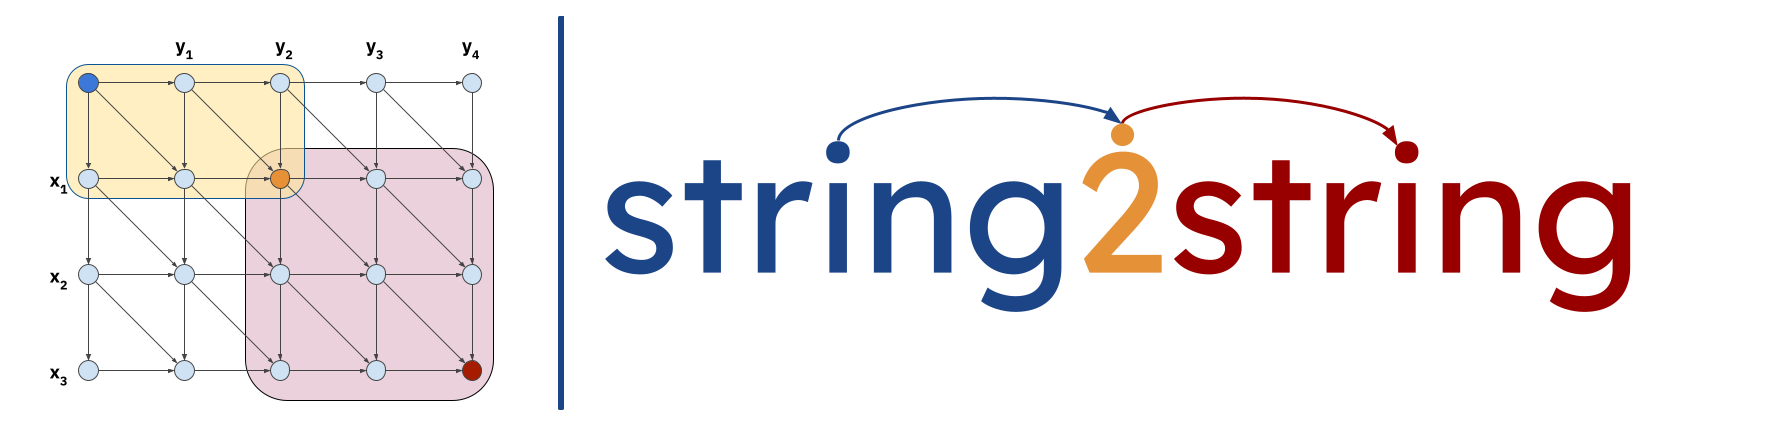

In this tutorial, we will show you how to use the string2string library to perform semantic search on and visualize a real-world natural-language processing dataset. In particular, we will be looking at a small subset of the Harvard USPTO Patent Dataset (HUPD; Suzgun et al., (2022)) and guide you through the process of performong semantic search via Facebook AI's Faiss tool and visualize the embeddings of the abstract sections of the patent applications for analysis. 

* With the help of this tutorial, you will, hopefully, be able to learn how to apply string2string for your own text analysis projects.

Without any further ado, let's get started!

## Getting Started

First and foremost, let's use `pip install` to install the string2string library.

In [1]:
%%capture
!pip install string2string
!pip install scikit-learn

We also need to import necessary libraries and dependencies.

In [2]:
# For data processing
import numpy as np
from collections import Counter

# To perform semantic search via Faiss
from string2string.search import FaissSearch

# To load HUPD
from datasets import load_dataset

# To perform dimensionality reduction
from sklearn.manifold import TSNE

# For visualization purposes (we will use both matplotlib and plotly)
%matplotlib inline
import matplotlib.pyplot as plt
from string2string.misc.plotting_functions import plot_corpus_embeds_with_plotly

/Users/machine/opt/anaconda3/envs/string2string/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Harvard USPTO Patent Dataset (HUPD)

We will be using HUPD as our data source of USPTO patent applications. 

* HUPD is a large-scale, well-structured, and multi-purpose corpus of 4.5M patent applications filed to the USPTO between 2004 and 2018. 

* For more details about HUPD, plese refer to [its GitHub repository](https://github.com/suzgunmirac/hupd).

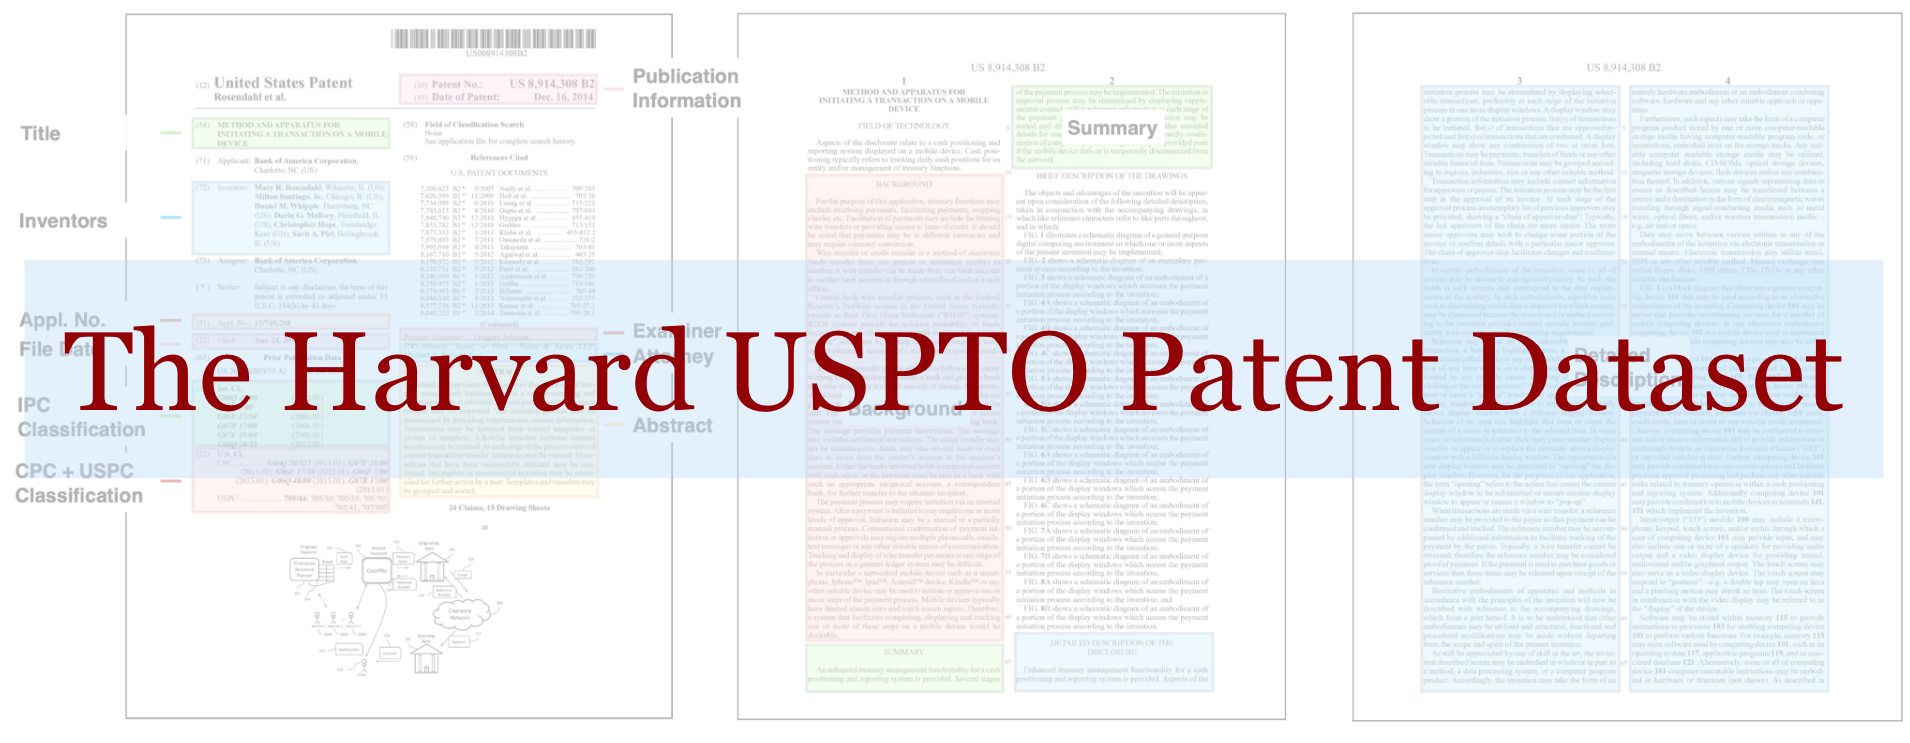


We will now load the dataset. For the purposes of this tutorial, we will be downloading and using a small subset of HUPD, which contains all the patent applications that were filed to the USPTO during the month of January in 2016. This subset alone, thought, includes about 25,000 USPTO patent documents.

In [3]:
# Load the dataset
dataset = load_dataset('HUPD/hupd',
    name='sample',
    data_files="https://huggingface.co/datasets/HUPD/hupd/blob/main/hupd_metadata_2022-02-22.feather", 
    icpr_label=None,
    train_filing_start_date='2016-01-01',
    train_filing_end_date='2016-01-21',
    val_filing_start_date='2016-01-22',
    val_filing_end_date='2016-01-31',
)

Using custom data configuration sample-21a949c4ad6ef021


Loading dataset with config: PatentsConfig(name='sample', version=0.0.0, data_dir='sample', data_files={'train': ['https://huggingface.co/datasets/HUPD/hupd/blob/main/hupd_metadata_2022-02-22.feather']}, description='Patent data from January 2016, for debugging')
Using metadata file: /Users/machine/.cache/huggingface/datasets/downloads/bac34b767c2799633010fa78ecd401d2eeffd62eff58abdb4db75829f8932710
Reading metadata file: /Users/machine/.cache/huggingface/datasets/downloads/bac34b767c2799633010fa78ecd401d2eeffd62eff58abdb4db75829f8932710
Filtering train dataset by filing start date: 2016-01-01
Filtering train dataset by filing end date: 2016-01-21
Filtering val dataset by filing start date: 2016-01-22
Filtering val dataset by filing end date: 2016-01-31


Dataset hupd downloaded and prepared to /Users/machine/.cache/huggingface/datasets/HUPD___hupd/sample-21a949c4ad6ef021/0.0.0/6920d2def8fd7767046c0470603357f76866e5a09c97e19571896bfdca521142. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 23.80it/s]


In [4]:
# Let's look at the dataet
dataset

DatasetDict({
    train: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'claims', 'background', 'summary', 'description', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id'],
        num_rows: 16153
    })
    validation: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'claims', 'background', 'summary', 'description', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id'],
        num_rows: 9094
    })
})

Patent applications are classified based on their technical subject matter, which is determined by standard taxonomies like IPC and CPC. These taxonomies use hierarchical codes, which can be lengthy and intricate. Thus, we will limit our analysis to the IPC codes of patent applications at the subclass level (such as G06F, H01L, A61B).

* To retrieve the IPC code labels of patent applications at the subclass level, we will utilize the `map(.)` function from the `datasets` library and add a new column to our dataset.

In [5]:
dataset = dataset.map(lambda ex: {"ipc_subclass_label": ex["ipc_label"][:4]})

100%|██████████| 9094/9094 [00:02<00:00, 3328.88ex/s]


While we are on procesing the dataset, let's also get rid of some extra columns in the dataset which we will not be using in this tutorial.

In [6]:
dataset = dataset.remove_columns(['claims', 'background', 'summary', 'description'])

In [7]:
# Let's display the dataset again
dataset

DatasetDict({
    train: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'ipc_subclass_label'],
        num_rows: 16153
    })
    validation: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'ipc_subclass_label'],
        num_rows: 9094
    })
})

In [8]:
# Get the most common 25 labels, along with their frequency.
ipc_label_freqs = Counter(dataset['train']['ipc_subclass_label']).most_common(25)

# Print the ipc_label_freqs
for (label, freq) in ipc_label_freqs:
    print(f'{label}: {freq}', end = ' | ')

G06F: 1406 | H01L: 882 | H04L: 735 | A61B: 577 | H04N: 563 | H04W: 530 | A61K: 493 | G06Q: 400 | G01N: 294 | G02B: 207 | G06T: 206 | A61M: 199 | H01M: 191 | C07D: 183 | A61F: 179 | C07K: 161 | G06K: 149 | G09G: 148 | C12N: 148 | H04B: 141 | G02F: 139 | B65D: 134 | B29C: 129 | H05K: 119 | G03G: 119 | 

In [9]:
# For convenience, let's excluse the abstracts that have longer than 180 words
dataset = dataset.filter(lambda ex: len(ex['abstract'].split(' ')) <= 180)

100%|██████████| 10/10 [00:00<00:00, 51.68ba/s]


## Initializing Faiss Semantic Search Tool

We will use the pre-trained HUPD Distil-RoBERTa model from Hugging Face Models.

In [10]:
# Let's download the HUPD DistilRoBERTa model 
model_name = 'HUPD/hupd-distilroberta-base'
faiss_search = FaissSearch(model_name_or_path = model_name)

Some weights of the model checkpoint at HUPD/hupd-distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at HUPD/hupd-distilroberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We have created an instance of our **Faiss Semantic Search** model, with HUPD Distil-RoBERTa as our language model. 

* We are now ready to initialize the corpus with the training set of the dataset.

In [11]:
# Let's initialize and process the corpus
faiss_search.initialize_corpus(
    corpus=dataset['train'],
    section='abstract', 
    embedding_type='mean_pooling',
    batch_size=16,
)

100%|██████████| 15724/15724 [34:55<00:00,  7.50ex/s]  


Adding FAISS index...


100%|██████████| 16/16 [00:00<00:00, 53.64it/s]


Dataset({
    features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'ipc_subclass_label', 'embeddings'],
    num_rows: 15724
})

In [12]:
# Let's get the embeddings, titles, and labels
patent_embeddings = np.array(faiss_search.dataset['embeddings']).squeeze()
patent_titles = faiss_search.dataset['title']
patent_ipc_subclass_labels = faiss_search.dataset['ipc_subclass_label']

In [13]:
# Let's print the shape of the patent_embeddings
print(patent_embeddings.shape) # (number of patents, embedding dimension)

(15724, 768)


## Dimensionality Reduction with t-SNE

The original patent abstract embeddings are 768-dimensional. We will use t-SNE to reduce the dimensionality to 2, so that we can visualize the embeddings in a 2D-space.

To accomplish this, we will use the sklearn.manifold.TSNE class. 
* We will use the default parameters but set the perplexity to 200. 
* Furthermore, we will set the random_state to 1729, so that we can reproduce the results.
* Finally, we wil set the verbose parameter to 1, so that we can see the progress of the algorithm.

Now, let's perform dimensionality reduction on the patent embeddings

In [14]:
# Initialize the TSNE model with the parameters we want to use for dimensionality reduction
# We will make use of the tSNE implementation from scikit-learn, with a random seed of 1729 for reproducibility purposes and a perplexity rate of 200
tsne = TSNE(n_components=2, perplexity=200, random_state=1729, verbose=1)

In [15]:
# Fit the model to the patent embeddings
tsne_embeddings = tsne.fit_transform(patent_embeddings)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 15724 samples in 0.003s...
[t-SNE] Computed neighbors for 15724 samples in 3.942s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15724
[t-SNE] Computed conditional probabilities for sample 2000 / 15724
[t-SNE] Computed conditional probabilities for sample 3000 / 15724
[t-SNE] Computed conditional probabilities for sample 4000 / 15724
[t-SNE] Computed conditional probabilities for sample 5000 / 15724
[t-SNE] Computed conditional probabilities for sample 6000 / 15724
[t-SNE] Computed conditional probabilities for sample 7000 / 15724
[t-SNE] Computed conditional probabilities for sample 8000 / 15724
[t-SNE] Computed conditional probabilities for sample 9000 / 15724
[t-SNE] Computed conditional probabilities for sample 10000 / 15724
[t-SNE] Computed conditional probabilities for sample 11000 / 15724
[t-SNE] Computed conditional probabilities for sample 12000 / 15724
[t-SNE] Computed conditional probabilities for sa

In [16]:
tsne_embeddings.shape

(15724, 2)

In [17]:
# Let's focus on the 10 most common labels for now
most_common_labels = [elt[0] for elt in ipc_label_freqs[1:10]]

## Visualization of the Embeddding Space

#### Visualize the embedding space using **matplotloib**.
Next we will use matplotlib to visualize the embeddings in a 2D-space.

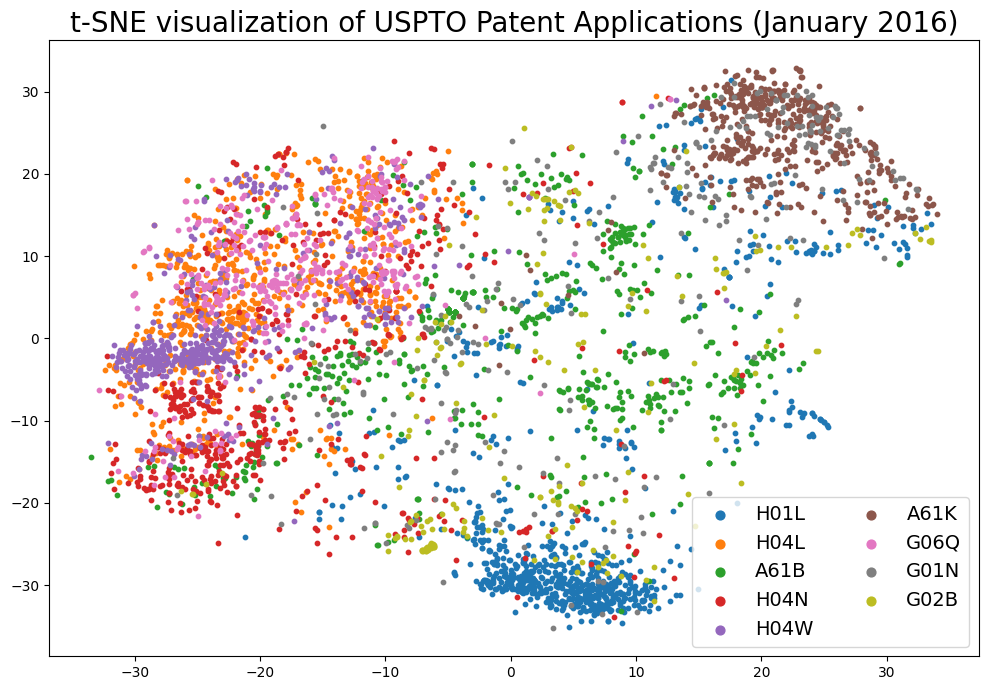

In [18]:
# Initialize the plot 
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
 
# For each label, we'll extract the corresponding points and plot them in the same color
for label in most_common_labels:
    # Find the samples of the current class in the data
    indices = [i for i, l in enumerate(patent_ipc_subclass_labels) if l == label]
 
    # Extract the coordinates of the points of this class only
    current_tx = np.take(tsne_embeddings[:, 0], indices)
    current_ty = np.take(tsne_embeddings[:, 1], indices)
 
    # Add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, label=label, s=10)
 
# build a legend using the labels we set previously
ax.legend(loc='best', fontsize=14, markerscale=2, ncol=2)
 
plt.title('t-SNE visualization of USPTO Patent Applications (January 2016)', fontsize=20)
# finally, show the plot
plt.show()

We can alternatively create an interactive plot using **plotly**!

In [23]:
def prepare_plotly_data(tsne_embeddings, patent_titles, patent_ipc_subclass_labels, most_common_labels):
    # Initialize the lists that will contain the tSNE coordinates, labels, titles, and hover texts (for matplotlib and plotly)
    tsne_coords = []
    tsne_labels = []
    tsne_titles = []
    tsne_hover_texts = []

    # Let's get the tSNE coordinates, labels, and titles for the most common labels
    for i, label in enumerate(patent_ipc_subclass_labels):
        if label in most_common_labels:
            tsne_coords.append(tsne_embeddings[i])
            tsne_labels.append(label)
            tsne_titles.append(patent_titles[i].title())
            tsne_hover_texts.append(f'Title: {patent_titles[i].title()}<br>Label: {label}')
    
    # Return the lists
    return tsne_coords, tsne_labels, tsne_titles, tsne_hover_texts

In [24]:
# Let's prepare the data for plotly
tsne_coords, tsne_labels, tsne_titles, tsne_hover_texts = prepare_plotly_data(
    tsne_embeddings, patent_titles, patent_ipc_subclass_labels, most_common_labels)

We will use the plot_corpus_embeds_with_plotly function from the string2string.misc.plotting_functions module, which makes use of the scatter function from the plotly.express module specifically to visualize the embeddings of a corpus of documents

In [25]:
# Let'x initialize the plotly layout
layoot_dict={
    "template":'simple_white',
    "legend_title_text":'IPC Codes',
    "legend_font_size":14,
    "height":800,
    "width":1200,
    "title": "tSNE Visualization of the Patent Embeddings of the Patents with the Most Common IPC Codes, with the Query Patent",
    "title_x":0.5,
    "xaxis_title":'Dimension 1',
    "yaxis_title":'Dimension 2'
}

In [26]:
# We are finally ready to plot the corpus embeddings with plotly! 
corpus_fig = plot_corpus_embeds_with_plotly(
    corpus_embeddings=tsne_coords,
    corpus_labels=tsne_labels,
    corpus_hover_texts=tsne_hover_texts,
    layoot_dict=layoot_dict,
    show_plot=True,
)

## Performing a Semantic Search Query on the Corpus

* Next, we will perform a semantic search query on the corpus. We will use the abstract of a famous patent application **(US 9733811 B2)** entitled *Matching process system and method for online dating services* by Tinder, Inc. as our query and find the ten most similar patents in the corpus.
* We will then visualize the results using the t-SNE visualization we created earlier.

Here is the abstract section of the Tinder patent application:

**Abstract**: "A method for profile matching includes receiving a plurality of user profiles, each user profile comprising traits of a respective user. The method includes receiving a preference indication for a first user profile of the plurality of user profiles. The method also includes determining a potential match user profile of the plurality of user profiles based on the preference indication for the first user profile. The method also includes presenting the potential match user profile to a second user."

In [27]:
# Here is the query we want to search for
query = 'A method for profile matching includes receiving a plurality of user profiles, each user profile comprising traits of a respective user. The method includes receiving a preference indication for a first user profile of the plurality of user profiles. The method also includes determining a potential match user profile of the plurality of user profiles based on the preference indication for the first user profile. The method also includes presenting the potential match user profile to a second user.'

# Let's get the top 10 results
results = faiss_search.search(query, k=10)

Let's print the most similar patent titles and their labels:

In [28]:
# Go over the results dataframe and print the title and the label of each patent
for i, row in results.iterrows():
    print(f'({i+1}) {row["title"].title()} ({row["ipc_subclass_label"]})')

(1) Social Network Based Mobile Access (H04L)
(2) Methods And Systems For Incentivizing, Exchanging And Tracking Expressions Of Gratitude Within A Network (G06F)
(3) System, Method, And Computer Program Product For Recommending Content To Users (G06F)
(4) Augmented Reality View Of Product Instructions (G06T)
(5) Managing Dynamic Webpage Content (G06F)
(6) Smoothing Peak System Load Via Behavior Prediction In Collaborative Systems With Temporal Data Access Patterns (H04L)
(7) Dynamic Interaction System And Method (G09B)
(8) Network-Aware Product Rollout In Online Social Networks (G06Q)
(9) Distributing Mobile Advertisements (G06Q)
(10) User Interface For A Mobile Device (G06F)


In [29]:
# Get the embeddings of the query and concatenate them with the patent embeddings
query_embeddings = faiss_search.get_embeddings([query], embedding_type="mean_pooling").detach().cpu().numpy()
concatenated_data = np.concatenate((patent_embeddings, query_embeddings), axis=0)

# Let's fit the tSNE model to the concatenated data
tsne_all_embeddings = tsne.fit_transform(concatenated_data) 

# Our query embeddings are the last 1 in the concatenated data
tsne_query_embeddings = tsne_all_embeddings[-1]

# Get the tSNE coordinates, labels, titles, and hover texts for the most common labels
tsne_coords, tsne_labels, tsne_titles, tsne_hover_texts = prepare_plotly_data(
    tsne_all_embeddings, patent_titles, patent_ipc_subclass_labels, most_common_labels)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 15725 samples in 0.004s...
[t-SNE] Computed neighbors for 15725 samples in 3.627s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15725
[t-SNE] Computed conditional probabilities for sample 2000 / 15725
[t-SNE] Computed conditional probabilities for sample 3000 / 15725
[t-SNE] Computed conditional probabilities for sample 4000 / 15725
[t-SNE] Computed conditional probabilities for sample 5000 / 15725
[t-SNE] Computed conditional probabilities for sample 6000 / 15725
[t-SNE] Computed conditional probabilities for sample 7000 / 15725
[t-SNE] Computed conditional probabilities for sample 8000 / 15725
[t-SNE] Computed conditional probabilities for sample 9000 / 15725
[t-SNE] Computed conditional probabilities for sample 10000 / 15725
[t-SNE] Computed conditional probabilities for sample 11000 / 15725
[t-SNE] Computed conditional probabilities for sample 12000 / 15725
[t-SNE] Computed conditional probabilities for sa

## Visualization of the Search Results

* We can plot both the corpus embeddings and the query embedding in the same plot! In this example, we will represent the query patent application embedding using a black dimaond. Its IPC code should ideally be close to G06F, G06Q, and H04L.

In [31]:
new_fig = plot_corpus_embeds_with_plotly(
    corpus_embeddings=tsne_coords,
    corpus_labels=tsne_labels,
    corpus_hover_texts=tsne_hover_texts,
    layoot_dict=layoot_dict,
    query_embeddings=[tsne_query_embeddings],
    query_labels=['Query'],
    query_hover_texts=['Query Patent'],
    query_modes='markers',
    query_marker_dict={
        "color": "black",
        "size": 24,
        "line": {
            "color": "white",
            "width": 2,
        },  
        "symbol": "diamond",
    },
    show_plot=True,
)

>  With this example, we have reached the end of this tutorial. We hope that you have found it useful. If you have any questions or suggestions, please feel free to contact us.

##### $\square$ Q.E.D.